In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Train directory: /kaggle/input/alzheimer-mri-dataset/Dataset
Using device: cuda
Epoch 1/10 - Train Loss: 1.3786 Acc: 0.3852 - 
Val Loss: 1.2447 Acc: 0.5086
Epoch 2/10 - Train Loss: 1.2248 Acc: 0.4930 - 
Val Loss: 1.1381 Acc: 0.5414
Epoch 3/10 - Train Loss: 1.1840 Acc: 0.5064 - 
Val Loss: 1.0876 Acc: 0.5594
Epoch 4/10 - Train Loss: 1.1100 Acc: 0.5471 - 
Val Loss: 1.0725 Acc: 0.5516
Epoch 5/10 - Train Loss: 1.0673 Acc: 0.5641 - 
Val Loss: 1.0045 Acc: 0.5797
Epoch 6/10 - Train Loss: 1.0419 Acc: 0.5510 - 
Val Loss: 0.9733 Acc: 0.5633
Epoch 7/10 - Train Loss: 0.9949 Acc: 0.5711 - 
Val Loss: 0.9541 Acc: 0.5813
Epoch 8/10 - Train Loss: 0.9569 Acc: 0.5711 - 
Val Loss: 0.9172 Acc: 0.5813
Epoch 9/10 - Train Loss: 0.9636 Acc: 0.5687 - 
Val Loss: 0.9063 Acc: 0.5883
Epoch 10/10 - Train Loss: 0.9378 Acc: 0.5658 - 
Val Loss: 0.8945 Acc: 0.5742


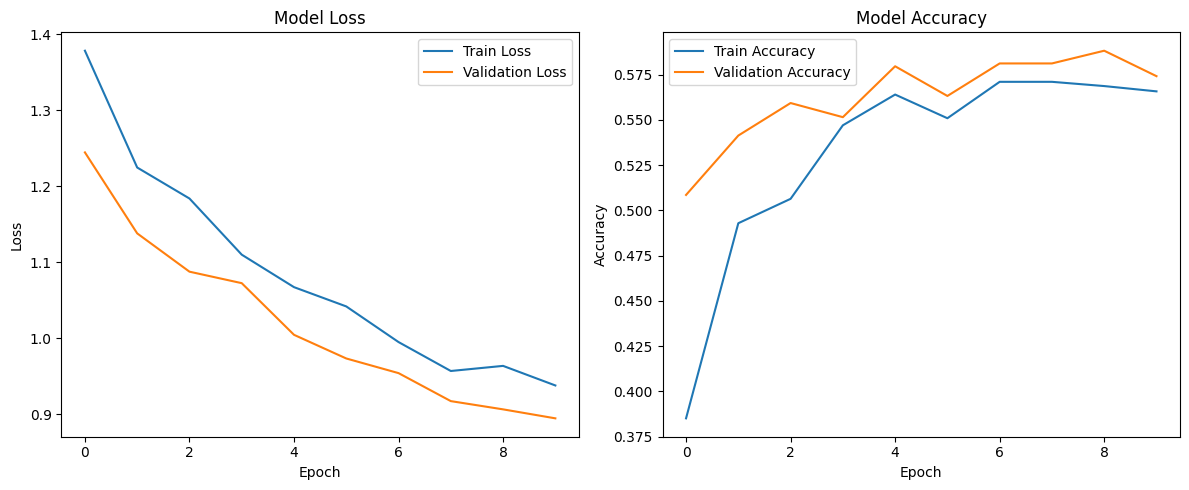


Анализ данных:
Количество тренировочных образцов: 5120
Количество валидационных образцов: 1280
Количество тестовых образцов: 2

Распределение классов (тренировочный набор):
Класс Mild_Demented: 896 образцов
Класс Moderate_Demented: 64 образцов
Класс Non_Demented: 3200 образцов
Класс Very_Mild_Demented: 2240 образцов

Среднее значение точности на валидационном наборе: 0.5629


In [7]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/alzheimer-mri-dataset/Dataset"

train_dir = os.path.join(root_dir)

print(f"Train directory: {train_dir}")


transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)
test_dataset = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512), 
    nn.Dropout(0.2),
    nn.Linear(512, len(train_dataset.classes))
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.fc. parameters(), momentum=0.9, lr=0.01)
def train_model(model, criterion, optimizer, num_epochs=20):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - \n'
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")